In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
from skimage import io, transform
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

In [2]:
#Importing the images
Image_path = 'D:\MTP_P1\W10\Trial_2D_TopDeep\Excel_data\img'
coll = skimage.io.ImageCollection(Image_path + '/*.png') 

#coll has the images as they are in the directory i.e is sorted order, also name of files can be viewed as coll.files[0] , shape as col[0].shape

# Now we will resize the image into 50*100 (width*length) , for that first we make a list as assignment is not allowed in ImageCollection, then push list itemps to a numpy array of required size
img_list = []
for i in range(len(coll)):
    img = transform.resize(coll[i], output_shape=(100,100))
    img_list.append(img)

img_arr = np.empty((120,100,100,3)) #initializes an empty numpy array which will contain 120 entries, each entry will be a 3 stacked matrices.
for i in range(120):
    img_arr[i] = np.asarray(img_list[i])


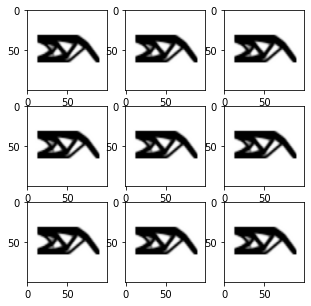

In [3]:
#visualizing the images
fig = plt.figure(figsize=(5, 5))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = img_arr[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [4]:
#now corresponding to each image we need an input tensor of size 50*100*3, matrices will contain volumefrac, fy , fx
top_set = np.empty((120,100,100,3))
#now we import our excel sheet which will provide the values with which we will populate our matrices
set_data = pd.read_excel("Top_setting.xlsx").values # .values will remove the headers i.e name of the columns

#updating the top_set to create our input with shape 120*50*100*3

for i in range(top_set.shape[0]):
    for j in range(top_set.shape[1]):
        for k in range(top_set.shape[2]):
            for l in range(top_set.shape[3]):
                top_set[i][j][k][l] = set_data[i][l]

# Now we have our input and outputs:
# input = top_set : shape - (120, 100, 100, 3)
# output = img_arr : shape - (120, 100, 100, 3)

In [5]:
#Now building The VAE Model

In [6]:
#create a sampling layer
class Sampling(layers.Layer):
    #uses (z_mean, z_log_var) to sample z, the vector encoding a digit
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [7]:
#Build the encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(100,100,3))
x = layers.Conv2D(30, 3, activation='relu',strides = 2, padding='same')(encoder_inputs)
x = layers.Conv2D(60, 3, activation='relu',strides = 2, padding ='same')(x)

conv_shape = keras.backend.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation ='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 30)   840         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 25, 60)   16260       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 37500)        0           ['conv2d_1[0][0]']         

In [8]:
print(conv_shape[1])
print(conv_shape[2])
print(conv_shape[3])
tf.__version__
keras.__version__

25
25
60


'2.10.0'

In [9]:
#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(latent_inputs)
x = layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)
x = layers.Conv2DTranspose(60, 3, activation = 'relu' , strides = 2, padding = 'same')(x)
x = layers.Conv2DTranspose(30, 3, activation = 'relu' , strides = 2, padding = 'same')(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation = 'sigmoid', padding = 'same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 37500)             112500    
                                                                 
 reshape (Reshape)           (None, 25, 25, 60)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 60)       32460     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 100, 100, 30)     16230     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 100, 100, 3)      813 

In [10]:
#Define the VAE as model with custom loss and train setup
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [13]:
#Train the VAE
X_train, X_test, y_train, y_test = train_test_split( top_set, img_arr, test_size=0.2, random_state=42)
# mnist_digits = np.concatenate([x_train, x_test], axis = 0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32')/255
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X = np.concatenate([X_train, X_test], axis = 0)
Y = np.concatenate([y_train, y_test], axis = 0)
vae = VAE(encoder , decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(Y,epochs=10, batch_size = 1)


Epoch 1/10
120/120 [==============================] - 3s 13ms/step - loss: 1357.9479 - reconstruction_loss: 1364.3246 - kl_loss: 0.0053
Epoch 2/10
120/120 [==============================] - 2s 18ms/step - loss: 1343.5189 - reconstruction_loss: 1353.1616 - kl_loss: 0.0071
Epoch 3/10
120/120 [==============================] - 2s 13ms/step - loss: 1296.2170 - reconstruction_loss: 1348.1294 - kl_loss: 0.0084
Epoch 4/10
120/120 [==============================] - 2s 13ms/step - loss: 1371.6321 - reconstruction_loss: 1347.0593 - kl_loss: 0.0108
Epoch 5/10
120/120 [==============================] - 1s 12ms/step - loss: 1333.0140 - reconstruction_loss: 1334.3262 - kl_loss: 0.0133
Epoch 6/10
120/120 [==============================] - 2s 14ms/step - loss: 1332.8158 - reconstruction_loss: 1339.2240 - kl_loss: 0.0149
Epoch 7/10
120/120 [==============================] - 2s 14ms/step - loss: 1317.7505 - reconstruction_loss: 1327.9624 - kl_loss: 0.0175
Epoch 8/10
120/120 [============================